# Quantitative Exercise - Task 1

## Step 1: Loading the data

In [1]:
from rdatasets import data

In [2]:
data = data('JohnsonJohnson')
data

,time,value
0,1960.00,0.71
1,1960.25,0.63
2,1960.50,0.85
3,1960.75,0.44
4,1961.00,0.61
...,...,...
79,1979.75,9.99
80,1980.00,16.20
81,1980.25,14.67
82,1980.50,16.02


## Step 2: Identify Independent and Dependent Variables

From the JohnsonJohnson dataset description, the dataset contains quarterly earnings (in cents) per Johnson & Johnson share. The data spans from 1960 to 1980. The independent variable is typically time (in this case, the quarters from 1960 to 1980), and the dependent variable would be the earnings per share.

Expected Properties:

Independent Variable (Time):
- Type: Numerical (Interval or Ratio)
- Range: Quarters from 1960 to 1980
- No missing values

Dependent Variable (Earnings per share):
- Type: Numerical (Ratio)
- Range: Varies depending on the company's performance
- No missing values, as it's a time series data and we expect values for each quarter.

## Step 3: Exploratory Data Analysis (EDA)

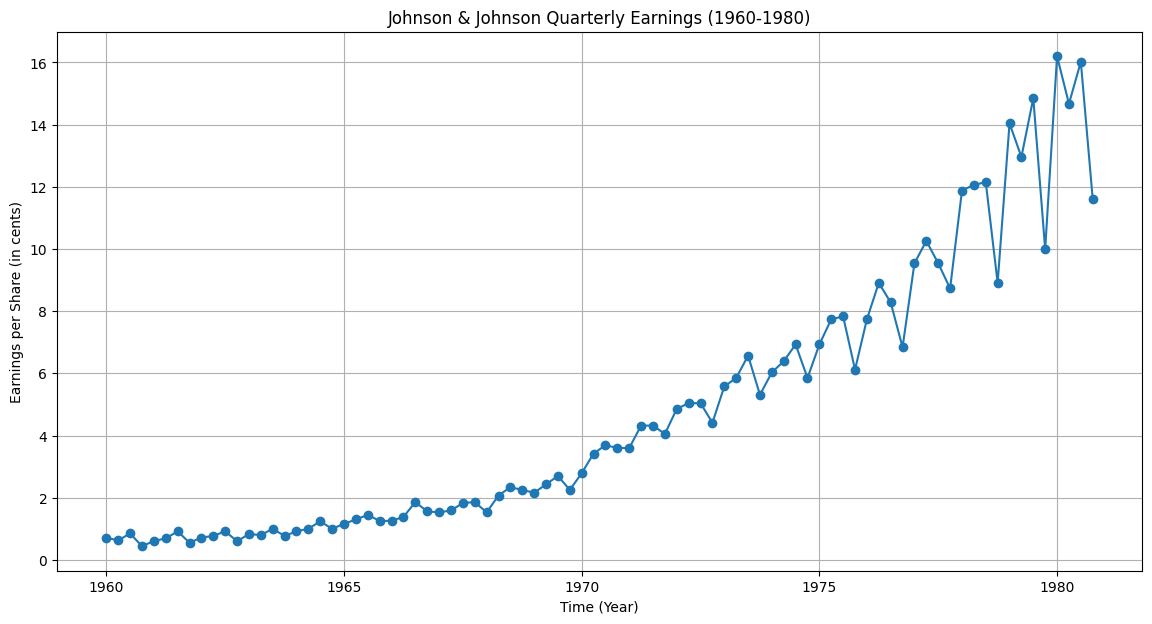

time     0
value    0
dtype: int64

In [3]:
import matplotlib.pyplot as plt

# Check for missing values
missing_values = data.isnull().sum()

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(data['time'], data['value'], marker='o', linestyle='-')
plt.title('Johnson & Johnson Quarterly Earnings (1960-1980)')
plt.xlabel('Time (Year)')
plt.ylabel('Earnings per Share (in cents)')
plt.grid(True)
plt.show()

missing_values

Based on the plotted data and the check for missing values we can see that:

+ There are no missing values in the dataset, which aligns with our expectations.
+ The plot showcases a clear cyclical pattern in the earnings, which is expected for a company with seasonal sales (e.g., higher sales during certain quarters).


## Step 4: Statistical Tools & Model Identification

Given the evident cyclical pattern in the data, time series decomposition can be a suitable method to understand the underlying trend, seasonality, and residual components of the series.
Before diving into model identification, let's first perform a basic statistical summary of the earnings data to get an idea of its distribution.

In [4]:
# Generate statistical summary of the earnings data
summary_stats = data['value'].describe()

summary_stats

count    84.000000
mean      4.799762
std       4.309991
min       0.440000
25%       1.247500
50%       3.510000
75%       7.132500
max      16.200000
Name: value, dtype: float64

Given the cyclical nature of the data, as well as the observed trend of increasing earnings over time, time series decomposition can be used to analyze the data further.

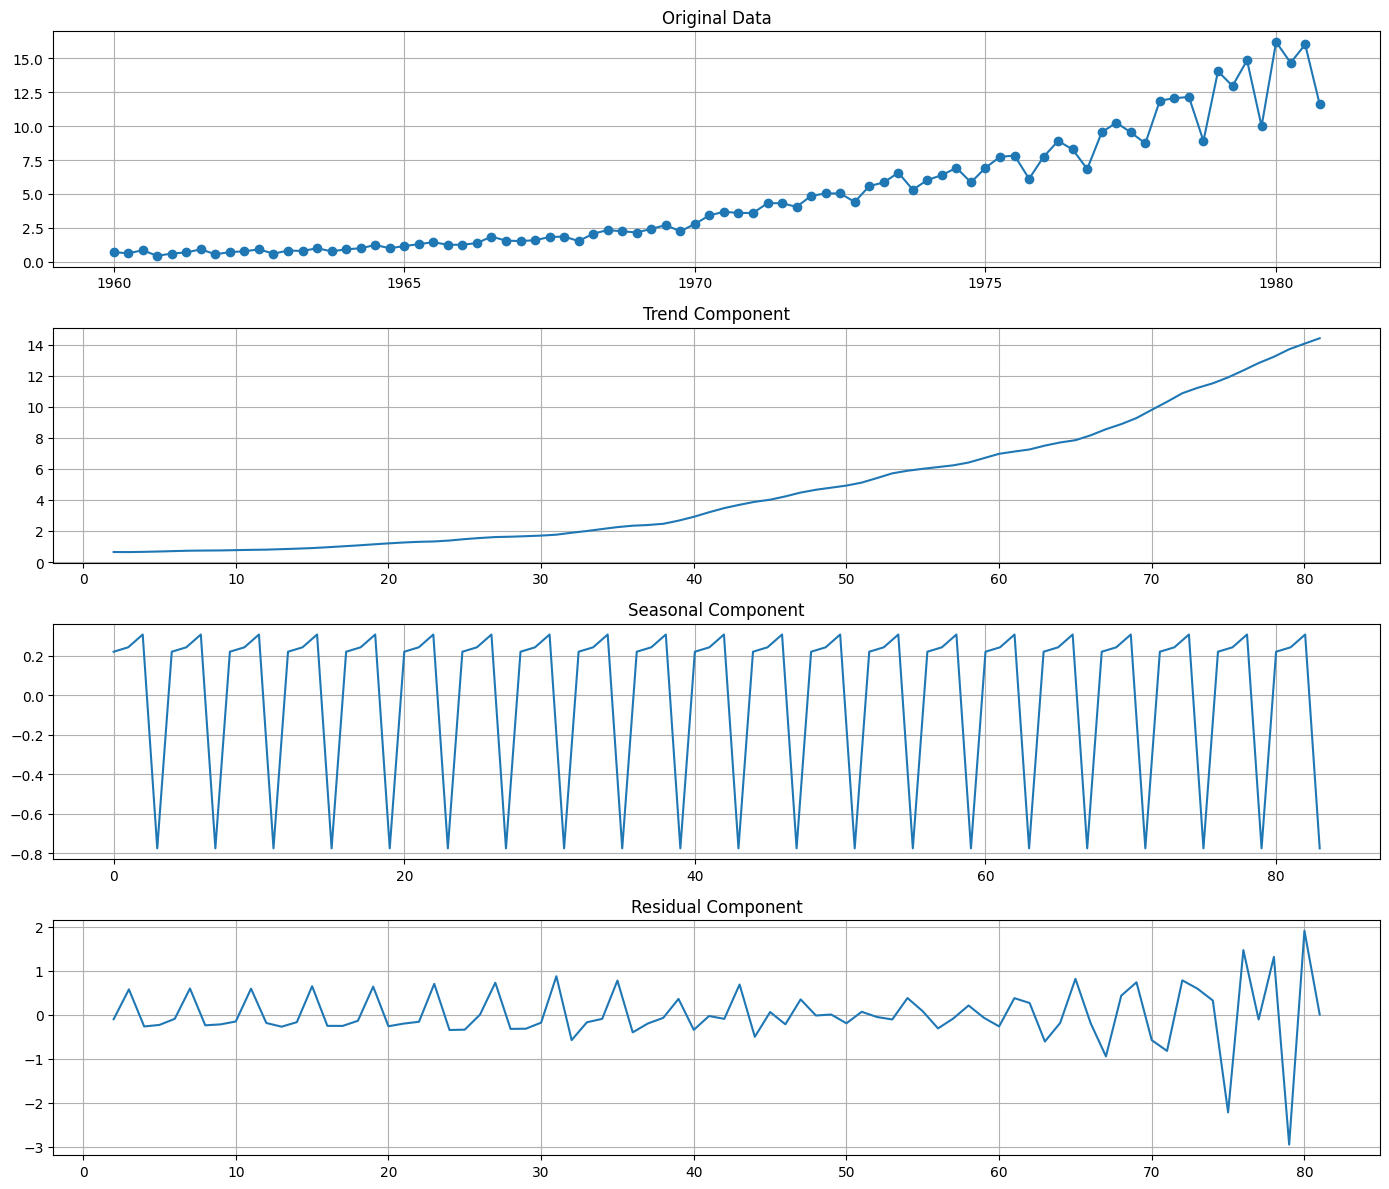

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
result = seasonal_decompose(data['value'], model='additive', period=4)  # Quarterly data, hence period=4

# Plotting the decomposition components
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(14,12))

# Original Data
ax1.plot(data['time'], data['value'], marker='o', linestyle='-')
ax1.set_title('Original Data')
ax1.grid(True)

# Trend Component
result.trend.plot(ax=ax2, title='Trend Component', grid=True)

# Seasonal Component
result.seasonal.plot(ax=ax3, title='Seasonal Component', grid=True)

# Residual Component
result.resid.plot(ax=ax4, title='Residual Component', grid=True)

plt.tight_layout()
plt.show()

From the time series decomposition, we can make the following observations:

+ Original Data: This shows the original quarterly earnings data, which exhibits a clear cyclical pattern.
+ Trend Component: The trend suggests a general increase in earnings over time. There are periods of faster growth followed by periods of slower growth.
+ Seasonal Component: This captures the repeating quarterly patterns in the data. There seems to be a consistent seasonal pattern every year, with one quarter exhibiting particularly high earnings (likely due to seasonal sales or other business-specific reasons).
+ Residual Component: After accounting for the trend and seasonality, the residuals capture the noise or irregularities in the data. This component should ideally be random, and it seems to be the case here with no clear patterns.


## Step 5:

In [6]:
# Splitting the data into training and testing sets (80-20 split)
train_size = int(0.8 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

train.shape, test.shape

((67, 2), (17, 2))

/Users/matteopancini/anaconda3/envs/rm/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RMSE: 3.620281481927646, MAE: 13.106438008388235


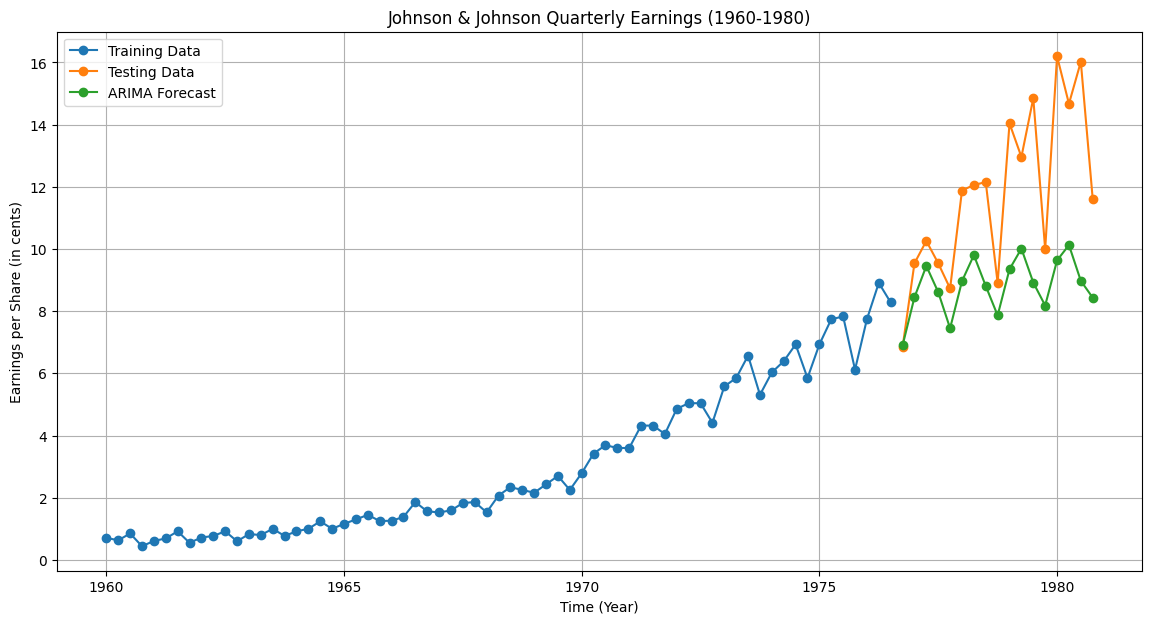

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fit ARIMA model
arima_model = ARIMA(train['value'], order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# Calculate RMSE and MAE
arima_rmse = mean_squared_error(test['value'], arima_forecast, squared=False)
arima_mae = mean_squared_error(test['value'], arima_forecast, squared=True)

print(f"RMSE: {arima_rmse}, MAE: {arima_mae}")

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(train['time'], train['value'], marker='o', linestyle='-', label='Training Data')
plt.plot(test['time'], test['value'], marker='o', linestyle='-', label='Testing Data')
plt.plot(test['time'], arima_forecast, marker='o', linestyle='-', label='ARIMA Forecast')
plt.title('Johnson & Johnson Quarterly Earnings (1960-1980)')
plt.xlabel('Time (Year)')
plt.ylabel('Earnings per Share (in cents)')
plt.legend()
plt.grid(True)
plt.show()

MSE: 16.545340664734447, MAE: 3.2577907337861904


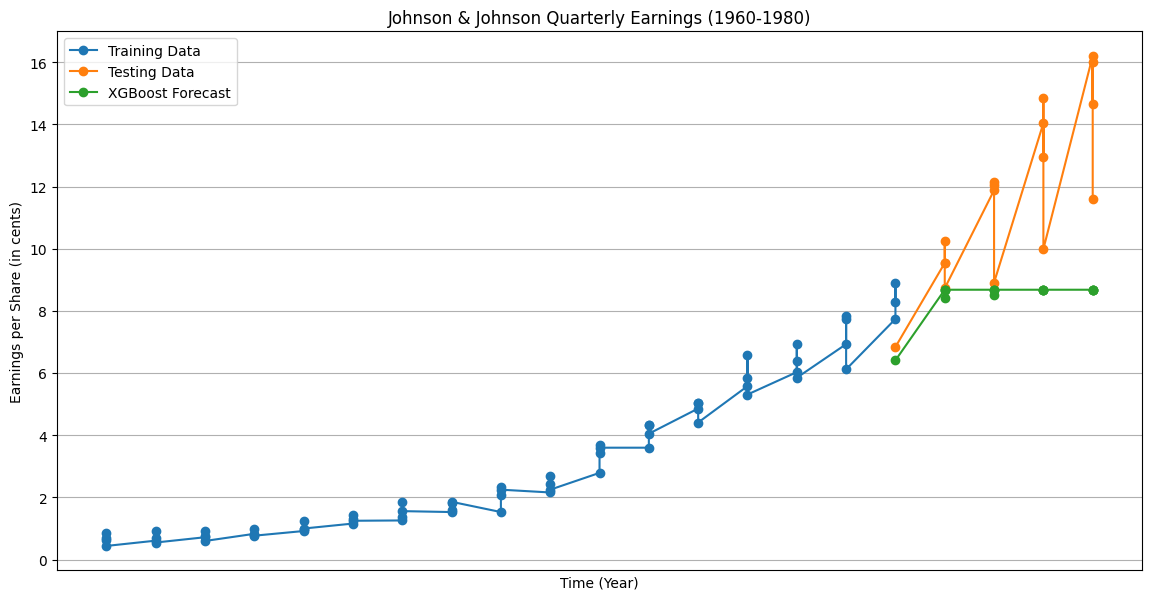

In [8]:
from xgboost import XGBRegressor
from mlforecast import MLForecast
import numpy as np
import pandas as pd

# Rename time column as ds and value column as y and add unique id column
train = train.rename(columns={'time': 'ds', 'value': 'y'})
test = test.rename(columns={'time': 'ds', 'value': 'y'})
train['unique_id'] = 1
test['unique_id'] = 1

# Df to timestamp
train['ds'] = pd.to_datetime(train['ds'])
test['ds'] = pd.to_datetime(test['ds'])


# Create the forecasting model
models = [XGBRegressor()]

fcst = MLForecast(
    models=models,
    freq='Q',
    lags=[7, 14, 21, 28]
)

# Fit the model
fcst.fit(train)

# Forecast for multiple sequence lengths and compute metrics
seq_length = len(test)

predictions = fcst.predict(seq_length)

y_values = test['y'].tolist()[:seq_length]
pred_values = predictions['XGBRegressor'].tolist()[:seq_length]

# Convert lists to numpy arrays
pred_values_array = np.array(pred_values)
y_values_array = np.array(y_values)

# Compute mse and mae
mse = ((pred_values_array - y_values_array) ** 2).mean()
mae = abs(pred_values_array - y_values_array).mean()

print(f"MSE: {mse}, MAE: {mae}")

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(train['ds'], train['y'], marker='o', linestyle='-', label='Training Data')
plt.plot(test['ds'], test['y'], marker='o', linestyle='-', label='Testing Data')
plt.plot(test['ds'], pred_values, marker='o', linestyle='-', label='XGBoost Forecast')
plt.title('Johnson & Johnson Quarterly Earnings (1960-1980)')
plt.xlabel('Time (Year)')
plt.ylabel('Earnings per Share (in cents)')
plt.legend()
plt.grid(True)
plt.show()